## Community Detection

In this notebook we will walk through a number of methods for community detection using a simple example dataset.




In [6]:
import numpy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import operator 

sys.path.append('../utils')
from utils import algorithm_u

%matplotlib inline

### Example graph

First let's create a simple graph that has two communities, each of which is fully connected, with one node from each community connected to a node in the other community.

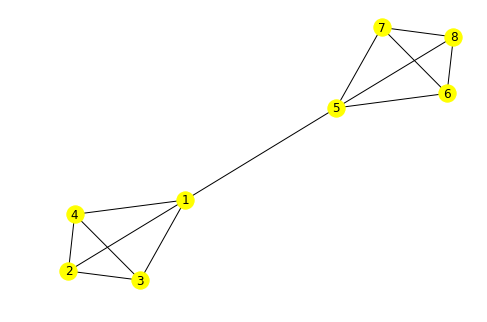

In [7]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges=[(1,2),(1,3),(1,4),(1,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8),(2,3),(2,4),(3,4)]
G.add_edges_from(edges)

nx.draw_spring(G,with_labels=True,node_color='yellow')

### Girvan-Newman method

The Girvan-Newman method is a *divisive* clustering method, meaning that it starts with the full graph and tries to find the best way to divide it into some number of clusters by removing particular edges.

The algorithm was defined by [Girvan & Newman (2002)](http://www.pnas.org/content/99/12/7821) as follows:

1. Calculate the betweenness for all edges in the network.
2. Remove the edge with the highest betweenness.
3. Recalculate betweennesses for all edges affected by the
removal.
4. Repeat from step 2 until no edges remain.

Let's implement this for the example dataset, finding two clusters.

In [88]:
n_clusters=len([i for i in nx.connected_components(G)])
G_tmp=G.copy()  # make a copy of the graph to work with
while n_clusters==1:
    # step 1: compute edge betweenness
    eb=nx.edge_betweenness(G_tmp)
    
    # step 2: remove the edge with highest betweeness
    # find the edge with the largest value of edge betweenness
    ebmax = max(eb.items(), key=operator.itemgetter(1))[0]
    # remove it from the graph
    G_tmp.remove_edges_from([ebmax])
    print('removing edge:',ebmax)
    
    # compute the number of connected components to see if we have
    # induced new clusters, and continue looping if not
    n_clusters=len([i for i in nx.connected_components(G_tmp)])
    
print('found two clusters:')
print([list(i.nodes) for i in nx.connected_component_subgraphs(G_tmp)])

removing edge: (1, 5)
found two clusters:
[[1, 2, 3, 4], [5, 6, 7, 8]]


### Modularity

One of the most commonly used set of methods for community detection rely upon the concept of *modularity*.  Here we will walk through the computation of modularity for a simple graph.

Here is one expression for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

At a glance this looks like a fairly modular graph. To compute modularity, we first need the adjacency matrix.

In [8]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0.]]


Next we need to generate the $\delta$ matrix denoting whether each pair of vertices is a member of the same community.

In [9]:
partition = [1,1,1,1,2,2,2,2]
delta = numpy.zeros((len(partition),len(partition)))
for i in range(len(partition)):
    for j in range(len(partition)):
        delta[i,j]=int(partition[i]==partition[j])
        
print(delta)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


The final thing we need is the expected edge frequency from the null model.  In general we want the null model to match the actual graph as closely as possible, except for the clustering. It is common to use a null model in which the degree sequence (i.e. the values of degrees for all nodes) is identical to the real graph; this is a more stringent null model than simply equating the degree distribution.  This null model can be written as (Fortunato, 2010):

$$
Q = \frac{1}{2m}\sum_{ij}\bigg(A_{ij} - \frac{k_i k_j}{2m}\bigg)\delta(C_i,C_j)
$$

where $k_i$ is the degree of vertex $i$.  Note that this null model will not necessarily give an identical degree sequence on any particular realization, but should be the same on average.

In [10]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
Q=0
for i in range(len(k)):
    for j in range(len(k)):
        Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
Q = Q/(2*m)

print(Q)

0.42307692307692296


We can compare our answer to the one given by the built-in modularity function in NetworkX:

In [11]:
nx.algorithms.community.quality.modularity(G,[{1,2,3,4},{5,6,7,8}])

0.42307692307692296

Now let's examine how modularity varies with the partition.  In this case, we can fairly easily compute all possible partitions of the 8 nodes and compute modularity for each.  In principle we should see that the modularity value is highest for the true partition.

In [12]:
Qvals=numpy.zeros(128)
partitions=[]
# loop through all possible partitions into two communities:

for i,p in enumerate(algorithm_u([1,2,3,4,5,6,7,8],2)):
    Qvals[i] = nx.algorithms.community.quality.modularity(G,p)
    partitions.append(p)


In [13]:
print('maximum Q:',Qvals.max())
print('best partition:',partitions[numpy.argsort(Qvals)[-1:][0]])

maximum Q: 0.42307692307692296
best partition: [[1, 2, 3, 4], [5, 6, 7, 8]]


### Modularity optimization

In general, it's not possible to perform exhaustive computation of modularity for all possible partitions (since this grows exponentially with the size of the graph), so a number of researchers have developed approximate methods that perform well in finding the partition with the maximum modularity value.

#### Greedy optimization

One approach (proposed initially by [Newman, 2004](https://pdfs.semanticscholar.org/29d4/dfae2807a67a2c66c720b4985cb599c4e245.pdf)) is to perform an *agglomerative* clustering using a ["greedy" algorithm ](https://en.wikipedia.org/wiki/Greedy_algorithm)- that is, an algorithm that makes the best possible choice at each point in the process, akin to climbing a hill by going the steepest upward direction at every point.

In Newman's greedy method, we start with each vertex in its own partition. We then find which combination of partitions would increase modularity the most, and combine those into one.

The implementation here would be far too inefficient to use with real data, but should help make clear how the algorithm works.

In [168]:
# create a function to compute modularity more easily
def modularity(G,partition):
    A = nx.to_numpy_array(G)
    m = len(G.edges)
    delta = numpy.zeros((len(partition),len(partition)))
    for i in range(len(partition)):
        for j in range(len(partition)):
            delta[i,j]=int(partition[i]==partition[j])
   
    k = [G.degree[i] for i in G.nodes] # degree values
    Q=0
    for i in range(len(k)):
        for j in range(len(k)):
            Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
    Q = Q/(2*m)
    return(Q)

Qvals=[-numpy.inf]
notbest=True
partition=numpy.array([1,2,3,4,5,6,7,8])  # initially assign all to the same

while notbest:
    unique_partitions=numpy.unique(partition)
    print('unique partitions:',unique_partitions)
    # loop through all combinations of unique partitions
    modvals={}
    for i in range(len(unique_partitions)):
        for j in range(i+1,len(unique_partitions)):
            if i==j:
                continue
            tmp_part=numpy.array(partition)
            tmp_part[tmp_part==unique_partitions[i]]=unique_partitions[j]
            
            modvals[(unique_partitions[i],unique_partitions[j])]=modularity(G,tmp_part)
    modmax = max(modvals.items(), key=operator.itemgetter(1))[0]
    if modvals[modmax]<numpy.max(numpy.array(Qvals)):
        print('breaking: found best Q value!')
        print(partition)
        notbest=False
    else:
        print(modmax,modvals[modmax])
        partition[partition==modmax[0]]=modmax[1]
        Qvals.append(modvals[modmax])


unique partitions: [1 2 3 4 5 6 7 8]
(2, 3) -0.07692307692307693
unique partitions: [1 3 4 5 6 7 8]
(3, 4) 0.02366863905325443
unique partitions: [1 4 5 6 7 8]
(1, 4) 0.14792899408284027
unique partitions: [4 5 6 7 8]
(6, 7) 0.19822485207100599
unique partitions: [4 5 7 8]
(7, 8) 0.2988165680473374
unique partitions: [4 5 8]
(5, 8) 0.42307692307692296
unique partitions: [4 8]
breaking: found best Q value!
[4 4 4 4 8 8 8 8]


### Spectral clustering

Another common method for community detection is spectral clustering, which uses the eigenvectors of matrices that describe the graph.  While we could work with the adjacency matrix, it is more common to use the [Laplacian matrix](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/), which you can think of as describing the flow of some quantity away from any particular node in the graph.

The Laplacian L is defined as:

$$
L = D - A
$$ 

where $A$ is the adjacency matrix, and $D$ is a diagonal matrix where each entry is the degree of that particular node. Here it is for our example graph:

In [17]:
D = numpy.zeros(A.shape)
D[numpy.diag_indices_from(D)]=k
L = D - A
print(L)

[[ 4. -1. -1. -1. -1.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  3.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1. -1. -1.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.  3.]]


In general, it's more useful to work with the normalized Laplacian, which normalizes by degree. We can compute this easily using linear algebra:

$$
Ln = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}
$$

In [20]:
Ln = numpy.linalg.inv(numpy.sqrt(D)).dot(L).dot(numpy.linalg.inv(numpy.sqrt(D)))
print(Ln)

[[ 1.         -0.28867513 -0.28867513 -0.28867513 -0.25        0.
   0.          0.        ]
 [-0.28867513  1.         -0.33333333 -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.25        0.          0.          0.          1.         -0.28867513
  -0.28867513 -0.28867513]
 [ 0.          0.          0.          0.         -0.28867513  1.
  -0.33333333 -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
   1.         -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
  -0.33333333  1.        ]]


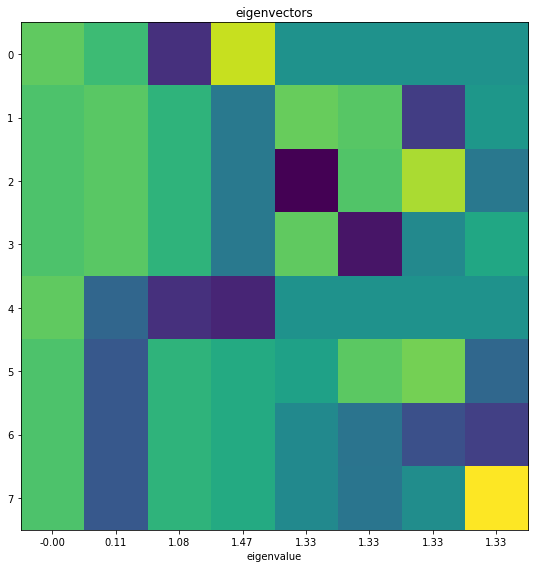

In [67]:
eig = numpy.linalg.eig(Ln)
def plot_eig(eig):
    plt.figure(figsize=(8,8))
    plt.imshow(eig[1])       # Get locations and labels
    _=plt.xticks([i for i in range(len(eig[0]))], ['%0.2f'%i for i in eig[0]])
    plt.xlabel('eigenvalue')
    plt.title('eigenvectors')
    plt.tight_layout()
    
plot_eig(eig)

Note that there is a single zero eigenvalue, which represents the fact that there is a single graph component.  Let's see what would happen if we were to add another component:

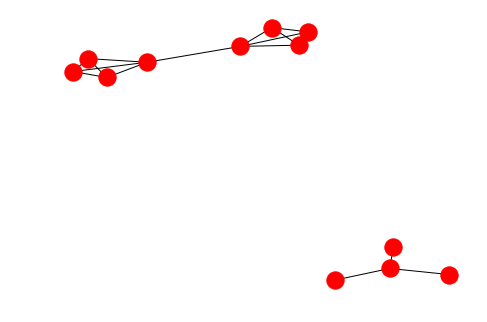

In [55]:
G_bigger = G.copy()
G_bigger.add_edges_from([(9,10),(10,11),(10,12)])
nx.draw_spring(G_bigger)

Now let's get the Laplacian matrix (this time using the built-in NetworkX function) and compute its eigenvalues.

In [69]:
Ln_bigger = nx.normalized_laplacian_matrix(G_bigger).todense()
eig_bigger=numpy.linalg.eig(Ln_bigger)
eig_bigger[0]

array([-1.11022302e-16,  1.13382475e-01,  1.08333333e+00,  1.46995086e+00,
        1.33333333e+00,  1.33333333e+00,  1.33333333e+00,  1.33333333e+00,
        2.00000000e+00,  1.00000000e+00, -1.00275610e-16,  1.00000000e+00])

Here you can see that there are two zero-valued eigenvalues, reflecting the fact that there are two components.

Now look back at the second column in the eigenvector matrix above, corresponding to the second largest eigenvalue.  Let's draw the graph and color the nodes according to the values of this second smallest eigenvalue:

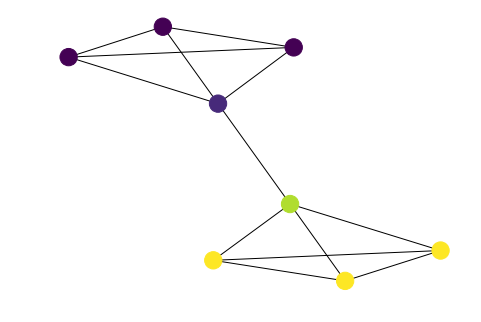

In [74]:
nx.draw_spring(G,node_color=eig[1][:,1],cmap='viridis')

What this shows is that the eigenvector corresponding to the smallest nonzero eigenvalue of the Laplacian matrix divides the graph by its major communities.

Spectral clustering methods take this approach further by treating each vertex in a metric space defined by the eigenvectors, and then using these to perform various clustering operations (e.g., k-means clustering).